# Sentence-level relation extraction with classic ML and LLM methods

## Dataset loading and review

In this experiment will be used dataset [SemEval 2010 Task 8](https://paperswithcode.com/dataset/semeval-2010-task-8). This dataset is open-sourced for anyone.

In [3]:
! pip install pandas pyarrow fsspec huggingface_hub spacy scipy sklearn matplotlib networkx transformers datasets torch tqdm

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import networkx as nx
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from tqdm import tqdm

In [5]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/SemEvalWorkshop/sem_eval_2010_task_8/" + splits["train"])

In [6]:
df.head()

,sentence,relation
0,The system as described above has its greatest...,3
1,The <e1>child</e1> was carefully wrapped and b...,18
2,The <e1>author</e1> of a keygen uses a <e2>dis...,11
3,A misty <e1>ridge</e1> uprises from the <e2>su...,18
4,The <e1>student</e1> <e2>association</e2> is t...,12


In [7]:
df['sentence'][0]

'The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>.'

In [8]:
len(df.relation.unique())

19

There are 19 unique types of relation in this dataset labels:

0 - Cause-Effect(e1,e2)

1 - Cause-Effect(e2,e1)

2 - Component-Whole(e1,e2)

3 - Component-Whole(e2,e1)

4 - Content-Container(e1,e2)

5 - Content-Container(e2,e1)

6 - Entity-Destination(e1,e2)

7 - Entity-Destination(e2,e1)

8 - Entity-Origin(e1,e2)

9 - Entity-Origin(e2,e1)

10 - Instrument-Agency(e1,e2)

11 - Instrument-Agency(e2,e1)

12 - Member-Collection(e1,e2)

13 - Member-Collection(e2,e1)

14 - Message-Topic(e1,e2)

15 - Message-Topic(e2,e1)

16 - Product-Producer(e1,e2)

17 - Product-Producer(e2,e1)

18 - Other


**18 number is used when there is no relation or relation is not of present types**

# Brief task description

Using the **classic ML** method we give the model vectors of features as the input. Model expected to return the predicted class of relations for every item.

Features will be extracted manually with special functions before vectorizing and data splitting.

Vectorizing will be done with TF-IDF-Vectorizer as it's one of the most used classic vectorizers. As the output we expect to have the array of numbers, each showing the relation type for it's sentence.

## Vectorizing with BERT

In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()

/opt/anaconda3/envs/practice_2025/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [21]:
def extract_entity_embeddings(sentences, device='cpu'):
    bert_model.to(device)
    embeddings = []

    for i, text in enumerate(tqdm(sentences)):
        text = str(text)

        if '[E1]' not in text or '[/E1]' not in text or '[E2]' not in text or '[/E2]' not in text:
            continue

        try:
            e1 = text.split('[E1]')[1].split('[/E1]')[0]
            e2 = text.split('[E2]')[1].split('[/E2]')[0]
        except IndexError:
            continue

        inputs_e1 = tokenizer(e1, return_tensors="pt")
        inputs_e2 = tokenizer(e2, return_tensors="pt")

        with torch.no_grad():
            out_e1 = bert_model(**inputs_e1).last_hidden_state.mean(dim=1)
            out_e2 = bert_model(**inputs_e2).last_hidden_state.mean(dim=1)

        combined = torch.cat((out_e1, out_e2), dim=1)
        embeddings.append(combined.numpy().flatten())

    return np.array(embeddings)

In [22]:
def mark_entities(sentence):
    sentence = sentence.replace('<e1>', '[E1]').replace('</e1>', '[/E1]')
    sentence = sentence.replace('<e2>', '[E2]').replace('</e2>', '[/E2]')
    return sentence

In [23]:
df['bert_input'] = df['sentence'].apply(mark_entities)
df.head()

,sentence,relation,bert_input
0,The system as described above has its greatest...,3,The system as described above has its greatest...
1,The <e1>child</e1> was carefully wrapped and b...,18,The [E1]child[/E1] was carefully wrapped and b...
2,The <e1>author</e1> of a keygen uses a <e2>dis...,11,The [E1]author[/E1] of a keygen uses a [E2]dis...
3,A misty <e1>ridge</e1> uprises from the <e2>su...,18,A misty [E1]ridge[/E1] uprises from the [E2]su...
4,The <e1>student</e1> <e2>association</e2> is t...,12,The [E1]student[/E1] [E2]association[/E2] is t...


In [24]:
X_bert = extract_entity_embeddings(df['bert_input'])

100%|██████████| 8000/8000 [15:31<00:00,  8.58it/s]


In [27]:
X_bert.shape

(8000, 1536)

## Data splitting

In [28]:
y = df['relation']
X_train, X_test, y_train, y_test = train_test_split(X_bert, y, test_size=0.2, random_state=42)

## Model learning and predicting

In [30]:
clf = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial', max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

In [31]:
y_pred = clf.predict(X_test)

## Metrics table

In [32]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.435     0.492     0.462        61
           1      0.650     0.659     0.655       138
           2      0.500     0.470     0.485       100
           3      0.571     0.577     0.574        97
           4      0.662     0.534     0.591        88
           5      0.853     0.690     0.763        42
           6      0.395     0.462     0.426       158
           8      0.320     0.308     0.314       107
           9      0.760     0.655     0.704        29
          10      0.625     0.357     0.455        14
          11      0.610     0.553     0.580        85
          12      0.750     0.529     0.621        17
          13      0.762     0.807     0.784       119
          14      0.681     0.602     0.639       103
          15      0.400     0.345     0.370        29
          16      0.610     0.545     0.576        66
          17      0.565     0.552     0.558        87
          18      0.362    

## Confusion matrix

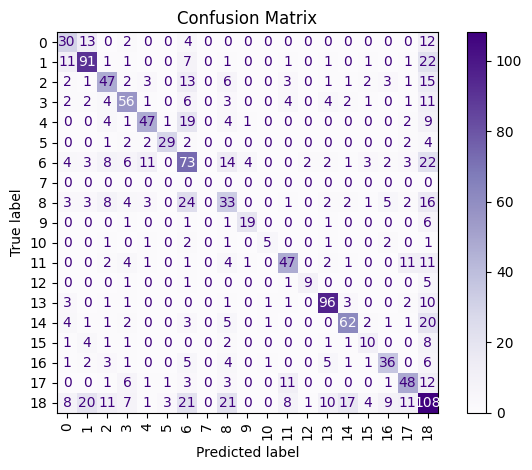

In [33]:
labels = sorted(df['relation'].unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90, cmap='Purples', values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Graph with predicted relations

In [34]:
relation_dict = {
    0: 'Cause-Effect(e1,e2)',
    1: 'Cause-Effect(e2,e1)',
    2: 'Component-Whole(e1,e2)',
    3: 'Component-Whole(e2,e1)',
    4: 'Content-Container(e1,e2)',
    5: 'Content-Container(e2,e1)',
    6: 'Entity-Destination(e1,e2)',
    7: 'Entity-Destination(e2,e1)',
    8: 'Entity-Origin(e1,e2)',
    9: 'Entity-Origin(e2,e1)',
    10: 'Instrument-Agency(e1,e2)',
    11: 'Instrument-Agency(e2,e1)',
    12: 'Member-Collection(e1,e2)',
    13: 'Member-Collection(e2,e1)',
    14: 'Message-Topic(e1,e2)',
    15: 'Message-Topic(e2,e1)',
    16: 'Product-Producer(e1,e2)',
    17: 'Product-Producer(e2,e1)',
    18: 'Other'
}

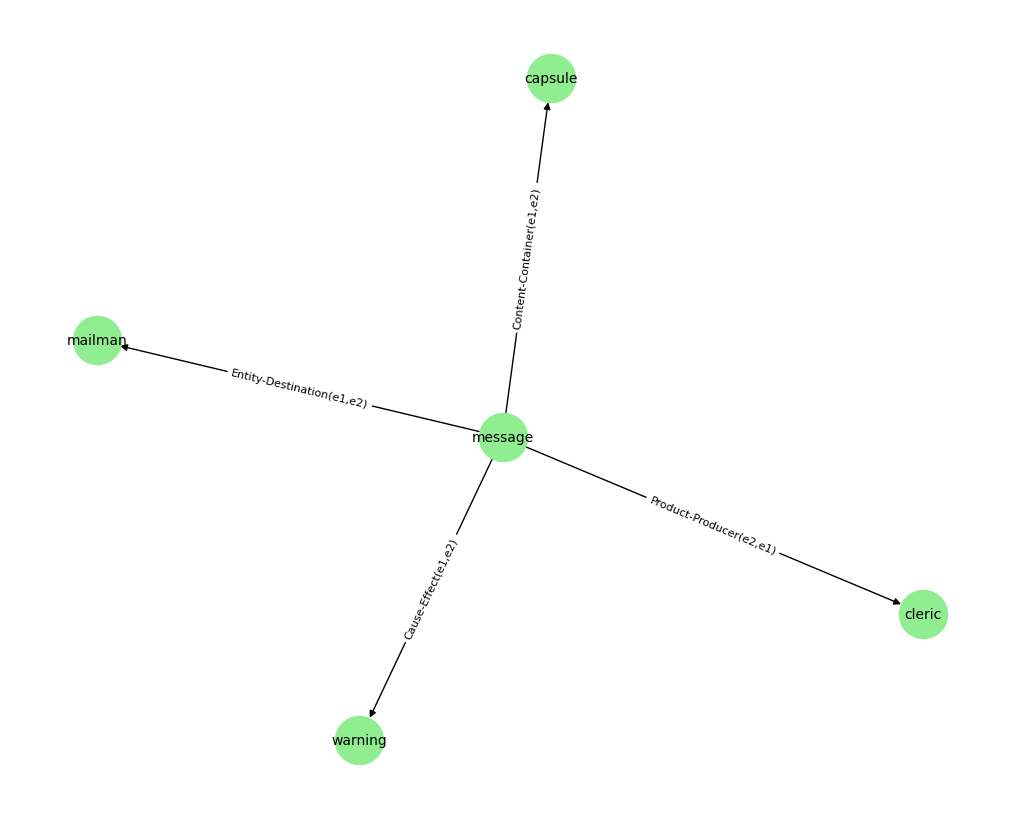

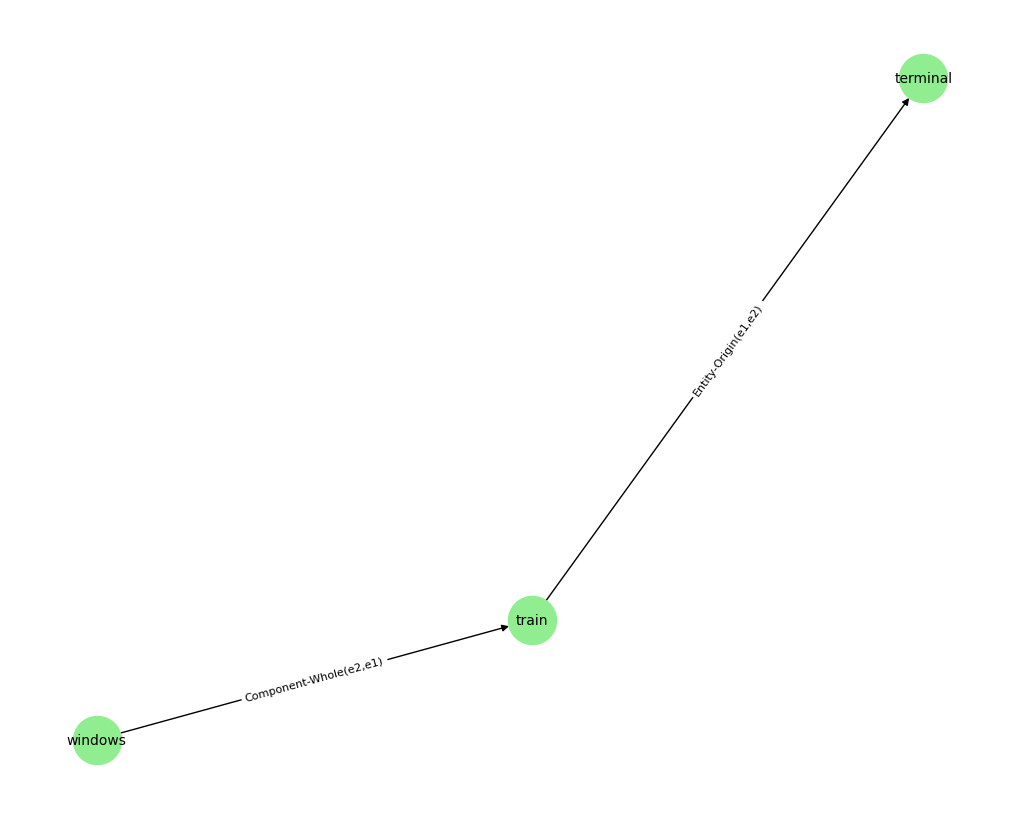

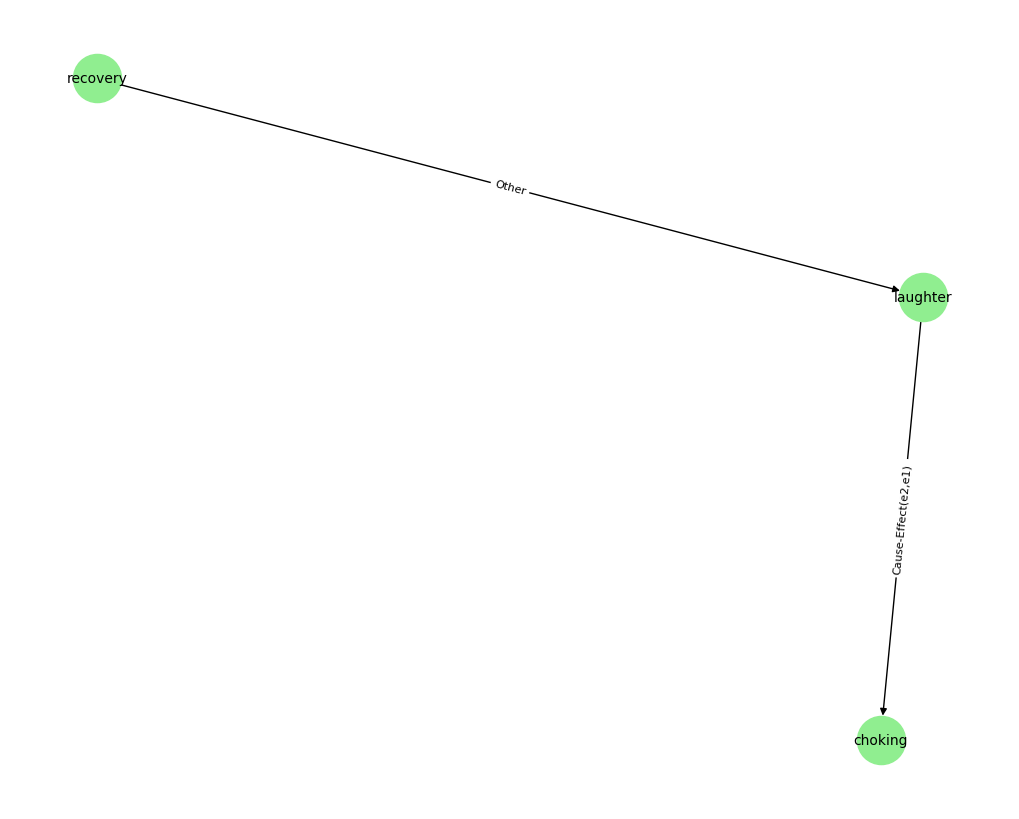

In [35]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
G = nx.DiGraph()

for i in range(min(len(df_test), 200)):
    row = df_test.iloc[i]
    pred_label = y_pred[i]
    relation = relation_dict[pred_label]

    sent = row['sentence']
    e1 = sent.split('<e1>')[1].split('</e1>')[0]
    e2 = sent.split('<e2>')[1].split('</e2>')[0]

    if '(e1,e2)' in relation:
        G.add_edge(e1, e2, label=relation)
    elif '(e2,e1)' in relation:
        G.add_edge(e2, e1, label=relation)
    else:
        G.add_edge(e1, e2, label=relation)

interesting_subgraphs = []
for component in nx.weakly_connected_components(G):
    subgraph = G.subgraph(component)
    if len(subgraph.nodes) >= 3 and len(subgraph.edges) >= 2:
        interesting_subgraphs.append(subgraph)


for idx, sg in enumerate(interesting_subgraphs[:3]):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(sg, k=1.5, iterations=100)
    
    nx.draw(sg, pos, with_labels=True, node_size=1200, node_color='lightgreen', font_size=10, arrows=True)
    edge_labels = nx.get_edge_attributes(sg, 'label')
    nx.draw_networkx_edge_labels(sg, pos, edge_labels=edge_labels, font_size=8)

    plt.show()